# Helium Hydride (Tapered HeH+) Exemplar
## Step 0: Import various libraries

In [10]:
# Imports for QSCOUT
import jaqalpaq
from jaqalpaq.core import circuitbuilder
from jaqalpaq.core.circuit import normalize_native_gates
from jaqalpaq import pygsti
from qscout.v1 import native_gates

# Imports for basic mathematical functionality
from math import pi
import numpy as np

# Imports for OpenFermion(-PySCF)
import openfermion as of
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf

# Import for VQE optimizer
from scipy import optimize

## Step 1: SCF calculation to assmble the second-quantized Hamiltonian

In [11]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 1 #Charge is 1 for HeH+

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
# Note: this option is critical as it ensures that the integrals are written out to an HDF5 file
delete_output = False

# Generate molecule at some bond length (0.8 Angstroms here)
geometry = [('He', (0., 0., 0.)), ('H', (0., 0., 0.8))]
molecule = MolecularData(
    geometry, basis, multiplicity, charge,    
    filename='./HeH+_2_sto-3g_single_0.8') #Set file location of data

# Run pyscf to generate new molecular data for sto-3g HeH+
molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)

print("Bond Length in Angstroms: {}".format(0.8))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 0.8
FCI (Exact) energy in Hartrees: -2.8557086272280108


## Step 2: Convert the fermionic Hamiltonian to a qubit Hamiltonian

In [12]:
#Get the Hamiltonian for HeH+
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
hamiltonian_bk = of.symmetry_conserving_bravyi_kitaev(hamiltonian_ferm, active_orbitals=4, active_fermions=2)

#Define terms and coefficients of our Hamiltonian
terms = []
cs = [] #Coefficients
for term in hamiltonian_bk.terms:
    paulis = [None, None]
    for pauli in term:
        paulis[pauli[0]] = pauli[1]
    terms += [paulis]
    cs += [hamiltonian_bk.terms[term]]

## Step 3: Define UCC Ansatz circuit in JaqalPaq

In [13]:
def ansatz(theta):
    term_probs = []
    for i in range(len(terms)):
        sexpr = [
            'circuit',
            #Define constants +-pi/2
            ('let', 'pi2', pi/2),
            ('let', 'npi2', -pi/2),

            #Create a qubit register
            ('register', 'q', 2),
            ('map', 'q0', 'q', 0),
            ('map', 'q1', 'q', 1),
            
            #Define a hadamard macro
            ('macro',
                'hadamard',
                'a',
                ('sequential_block',
                    ('gate', 'Sy', 'a'),
                    ('gate', 'Px', 'a'),
                ),
            ),

            #Prepare the state |11>
            ('gate', 'prepare_all'),
            ('gate', 'Px', 'q0'),
            ('gate', 'Px', 'q1'),

            #Apply the UCC Ansatz exp[-i*theta(X1 Y0)]
            ('gate', 'MS', 'q1', 'q0', 'npi2', 0),
            ('gate', 'Rz', 'q1', theta),
            ('gate', 'MS', 'q1', 'q0', 'pi2', 0),
        ]
        
        #Change basis for measurement depending on term
        for j, qubit in enumerate(terms[i]):
            if qubit == 'X':
                sexpr+=('gate', 'hadamard', ('array_item', 'q', j)),
            if qubit == 'Y':
                sexpr+=('gate', 'Sxd', ('array_item', 'q', j)),
        sexpr+=('gate', 'measure_all'),
       
        circuit=circuitbuilder.build(sexpr, native_gates=normalize_native_gates(native_gates.NATIVE_GATES))

        #Format results of simulation as a list of lists
        sim_result = pygsti.forward_simulate_circuit(circuit)
        probs = []
        for state in sim_result:
            probs += [sim_result[state]] #Append probabilities of each state for a particular term
        term_probs += [probs] #Combine lists of probabilities of each term in Hamiltonian
    return term_probs

## Step 4: Define functions to calculate energy expectation value of Ansatz state

In [14]:
#Calculate energy of one term of the Hamiltonian for one possible state
def term_energy(term, state, coefficient, prob):
    parity = 1
    for i in range(len(term)):
        #Change parity if state is occupied and is acted on by a pauli operator
        if term[i] != None and state[i] == '1':
            parity = -1*parity
    return coefficient*prob*parity

#Calculate energy of the molecule for a given value of theta
def calculate_energy(theta):
    energy = 0
    probs = ansatz(theta[0]) #Convert tuple (from optimization) to float for circuit
    for i in range(len(terms)): #For each term in the hamiltonian
        for j in range(len(probs[0])): #For each possible state
            term = terms[i]
            state = '{0:02b}'.format(j) #convert state to binary (# of qubits)
            coefficient = cs[i].real
            prob = probs[i][j]
            energy += term_energy(term, state, coefficient, prob)
    return energy

## Step 5: Minimize the energy expectation value in 𝜃

In [15]:
#Minimize the energy using classical optimization
optimize.minimize(fun=calculate_energy, x0=[0.01], method="COBYLA") #Can use "L-BFGS-B" instead

     fun: -2.8553440224484588
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 21
  status: 1
 success: True
       x: array([3.01410625])

## Step 6: Loop over previous steps to calculate ground state energy at different bond lengths

In [16]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 1

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
# Note: this option is critical as it ensures that the integrals are written out to an HDF5 file
delete_output = False

optimized_energies = []
exact_energies = []

#Loop over bond lengths from 0.5 to 2.0 angstroms
n_pts = 16 #Number of points
bond_lengths = np.linspace(0.5,2.0,n_pts)
for diatomic_bond_length in bond_lengths:
    # Generate molecule at some bond length
    geometry = [('He', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, charge,
        description=str(round(diatomic_bond_length, 2)),
        filename='./HeH+_2_sto-3g_single_dissociation')

    # Run pyscf
    molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)
    
    # Get the fermionic Hamiltonian for H2 and map it into qubits using the Bravyi-Kitaev encoding
    hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
    hamiltonian_bk = of.symmetry_conserving_bravyi_kitaev(hamiltonian_ferm, active_orbitals=4, active_fermions=2)

    #Define terms and coefficients of our Hamiltonian
    terms = []
    cs = [] #Coefficients
    for term in hamiltonian_bk.terms:
        paulis = [None, None]
        for pauli in term:
            paulis[pauli[0]] = pauli[1]
        terms += [paulis]
        cs += [hamiltonian_bk.terms[term]]

    # Minimize the expectation value of the energy using a classical optimizer (COBYLA)
    result = optimize.minimize(fun=calculate_energy, x0=[0.01], method="COBYLA")
    optimized_energies.append(result.fun)
    exact_energies.append(molecule.fci_energy)
    print("R={}\t Optimized Energy: {}".format(str(round(diatomic_bond_length, 2)), result.fun))

R=0.5	 Optimized Energy: -2.6406229389968803
R=0.6	 Optimized Energy: -2.7698461628810396
R=0.7	 Optimized Energy: -2.8302229108137475
R=0.8	 Optimized Energy: -2.8553440224484588
R=0.9	 Optimized Energy: -2.862169903427371
R=1.0	 Optimized Energy: -2.859724487518574
R=1.1	 Optimized Energy: -2.853064749450981
R=1.2	 Optimized Energy: -2.8450534872858806
R=1.3	 Optimized Energy: -2.837227111519151
R=1.4	 Optimized Energy: -2.8303157830182406
R=1.5	 Optimized Energy: -2.8245835165008115
R=1.6	 Optimized Energy: -2.82004020419945
R=1.7	 Optimized Energy: -2.8165661765781778
R=1.8	 Optimized Energy: -2.813985968588915
R=1.9	 Optimized Energy: -2.8121135325585924
R=2.0	 Optimized Energy: -2.810778636854449


## Step 7: Plot the dissociation curve

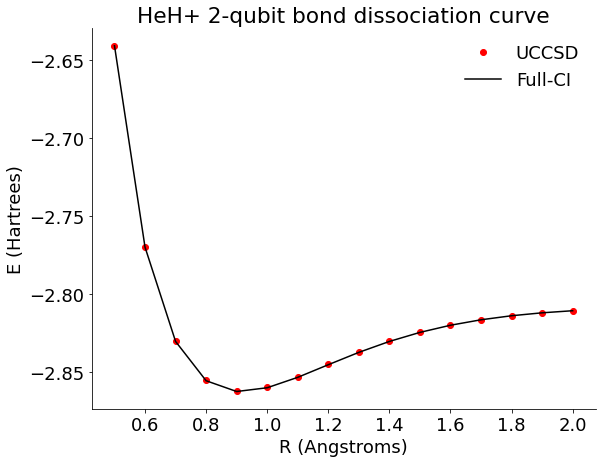

In [19]:
import matplotlib
import matplotlib.pyplot as pyplot

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(10,7))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'HeH+ 2-qubit bond dissociation curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, optimized_energies, 'o', label='UCCSD', color='red')
ax.plot(bond_lengths, exact_energies, '-', label='Full-CI', color='black')

ax.legend(frameon=False)
pyplot.show()

fig.savefig("HeH+ Bond Dissociation Curve.pdf")